<a href="https://colab.research.google.com/github/Nikolaos-Cavadias/Machine-learning-for-Prediction-of-Fluid-Flows/blob/main/github_POD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from scipy.io import loadmat

# File paths in Google Drive
csv_file_path = '/content/drive/My Drive/DISSERTATION/pod_data.csv'
#mat_file_path = '/content/drive/My Drive/DISSERTATION/channel_rods_grid1hfin1mid.mat'

# Load data
try:
    data = np.loadtxt(csv_file_path, delimiter=",", skiprows=1).T
    print("CSV data loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")



CSV data loaded successfully.


In [ ]:
UNORMALISED_data=data
print("load data done")




# Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Separate into training and prediction sets
train_data = data[:360]
predict_data = data[360:]

# Parameters
sequence_length = 20
batch_size = 8192
num_features = data.shape[1]
hidden_size = 512 # Increase hidden size for a more complex model
num_layers = 3  # Use multiple LSTM layers for better learning
prediction_length = 90
dropout=0.3


load data done


In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset

# Custom Dataset for generating sequences
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        X = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.float32)
        y = torch.tensor(self.data[idx + self.seq_len], dtype=torch.float32)
        return X, y

# First, split the raw data
train_data = data[:360]  # First 480 timesteps + seq_len extra for last valid sequence
val_data = data[360:]  # Rest for validation

# Now, create separate datasets for train and validation
train_dataset = SequenceDataset(train_data, sequence_length)
val_dataset = SequenceDataset(val_data, sequence_length)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


In [ ]:
# Define LSTM Model with multiple layers
class TemperatureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout, bidirectional=True):
        super(TemperatureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

model = TemperatureLSTM(num_features, hidden_size, num_features, num_layers, dropout, bidirectional=True)
criterion = nn.MSELoss()
#criterion = torch.nn.HuberLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

#SCHEDULER
from torch.optim.lr_scheduler import StepLR

# Scheduler: Reduce LR by a factor of 0.5 every 10 epochs
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)



Epoch 1, LR: 0.000300
Epoch [1/600], Train Loss: 0.2550, Validation Loss: 0.2321, Train Accuracy: -4.9670, Validation Accuracy: -4.4806
Epoch 2, LR: 0.000300
Epoch [2/600], Train Loss: 0.2318, Validation Loss: 0.2082, Train Accuracy: -4.4246, Validation Accuracy: -3.9162
Epoch 3, LR: 0.000300
Epoch [3/600], Train Loss: 0.2079, Validation Loss: 0.1800, Train Accuracy: -3.8646, Validation Accuracy: -3.2506
Epoch 4, LR: 0.000300
Epoch [4/600], Train Loss: 0.1799, Validation Loss: 0.1437, Train Accuracy: -3.2104, Validation Accuracy: -2.3936
Epoch 5, LR: 0.000300
Epoch [5/600], Train Loss: 0.1439, Validation Loss: 0.0963, Train Accuracy: -2.3673, Validation Accuracy: -1.2740
Epoch 6, LR: 0.000300
Epoch [6/600], Train Loss: 0.0965, Validation Loss: 0.0482, Train Accuracy: -1.2573, Validation Accuracy: -0.1390
Epoch 7, LR: 0.000300
Epoch [7/600], Train Loss: 0.0483, Validation Loss: 0.1076, Train Accuracy: -0.1294, Validation Accuracy: -1.5398
Epoch 8, LR: 0.000300
Epoch [8/600], Train Loss:

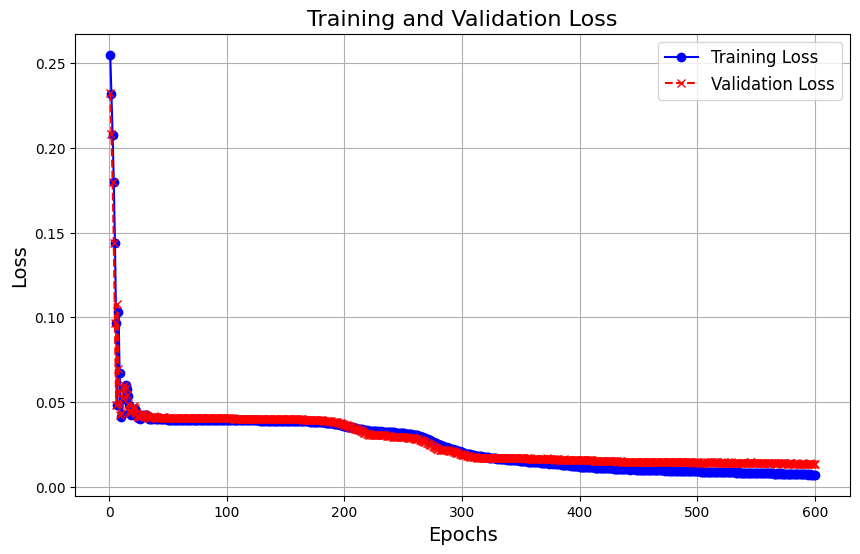

In [ ]:
# Define R² score calculation function
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Training with increased epochs
num_epochs = 600  # Increase epochs for better training
# Training Loop with Accuracy Tracking
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

## chatgpt code
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    batch_train_losses, batch_train_accuracies = [], []

    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

        # Calculate accuracy for this batch
        with torch.no_grad():
            r2 = r2_score(y_batch.cpu().numpy(), output.cpu().numpy())
            batch_train_accuracies.append(r2)


    #SCHEDULER
    # Step the scheduler at the end of each epoch
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]:.6f}")



    # Calculate average training loss and accuracy for this epoch
    train_loss = np.mean(batch_train_losses)  # Add this line
    train_losses.append(train_loss)
    train_accuracy = np.mean(batch_train_accuracies)  # Add this line
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_batch_losses, val_batch_accuracies = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_batch_losses.append(loss.item())

            r2 = r2_score(y_batch.cpu().numpy(), output.cpu().numpy())
            val_batch_accuracies.append(r2)

    # Calculate average validation loss and accuracy for this epoch
    val_loss = np.mean(val_batch_losses)  # Add this line
    val_losses.append(val_loss)
    val_accuracy = np.mean(val_batch_accuracies)  # Add this line
    val_accuracies.append(val_accuracy)

    # Print progress every 10 epochs
    # if (epoch) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', linestyle='--', marker='x')

# Adding labels, title, and legend
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()


# Prediction and R² calculation
model.eval()
predictions = []
input_seq = torch.tensor(train_data[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)

for _ in range(prediction_length):
    with torch.no_grad():
        pred = model(input_seq).squeeze(0).cpu().numpy()
        predictions.append(pred)
        input_seq = torch.cat((input_seq[:, 1:, :], torch.tensor(pred).unsqueeze(0).unsqueeze(1).to(device)), dim=1)

predicted_data = np.array(predictions)
predicted_data = scaler.inverse_transform(predicted_data)

# Calculate R² for each time step
actual_data = scaler.inverse_transform(predict_data)
# Uncomment if R² scores per time step are needed
# r2_scores = [r2_score(actual_data[i], predicted_data[i]) for i in range(prediction_length)]





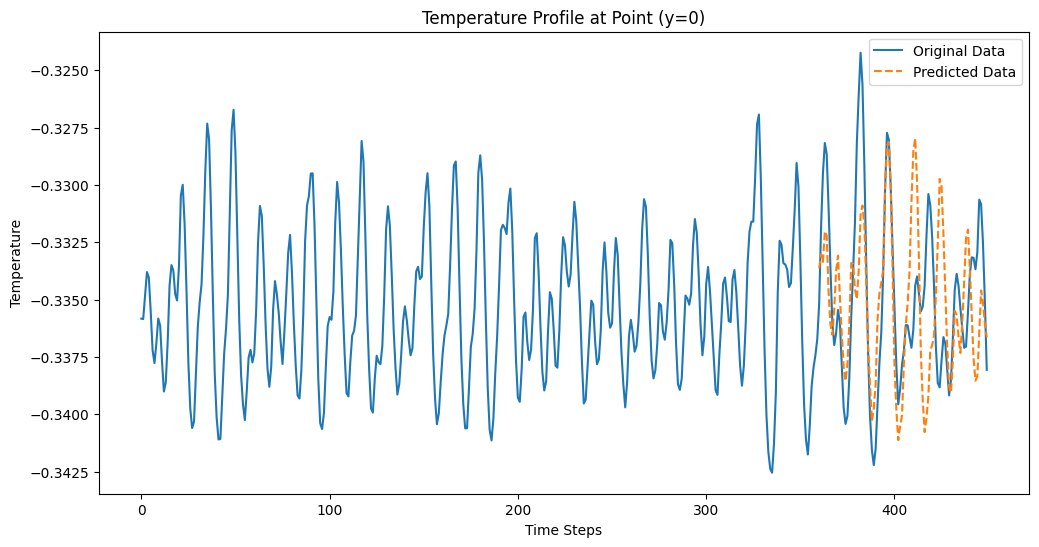

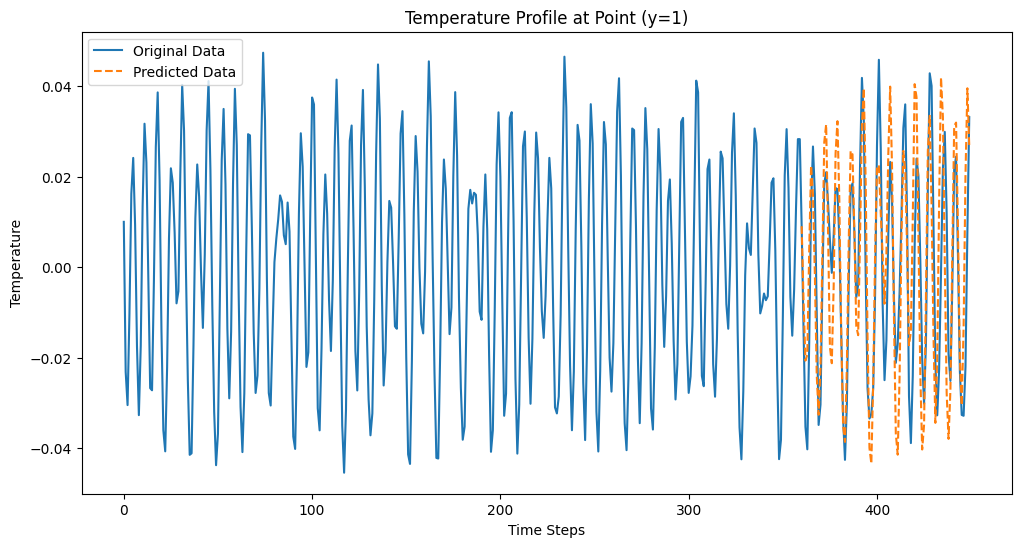

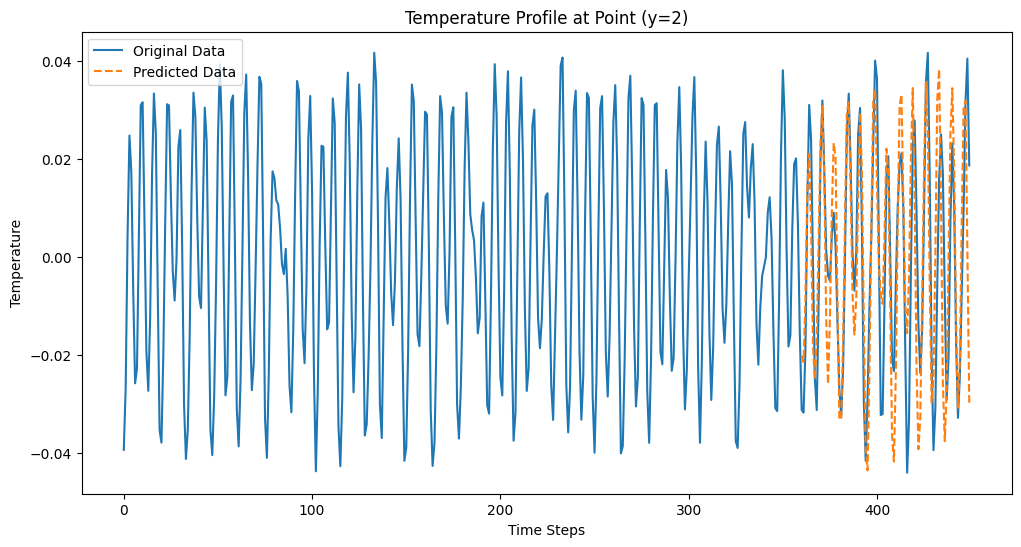

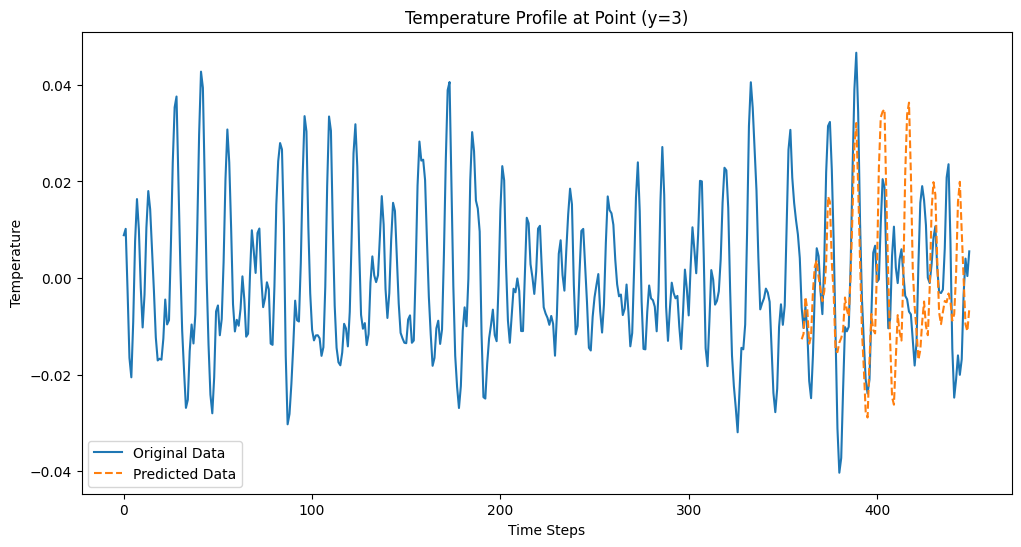

In [ ]:

closest_index = 0


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()




closest_index = 1


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()


closest_index = 2


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()


closest_index = 3


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()




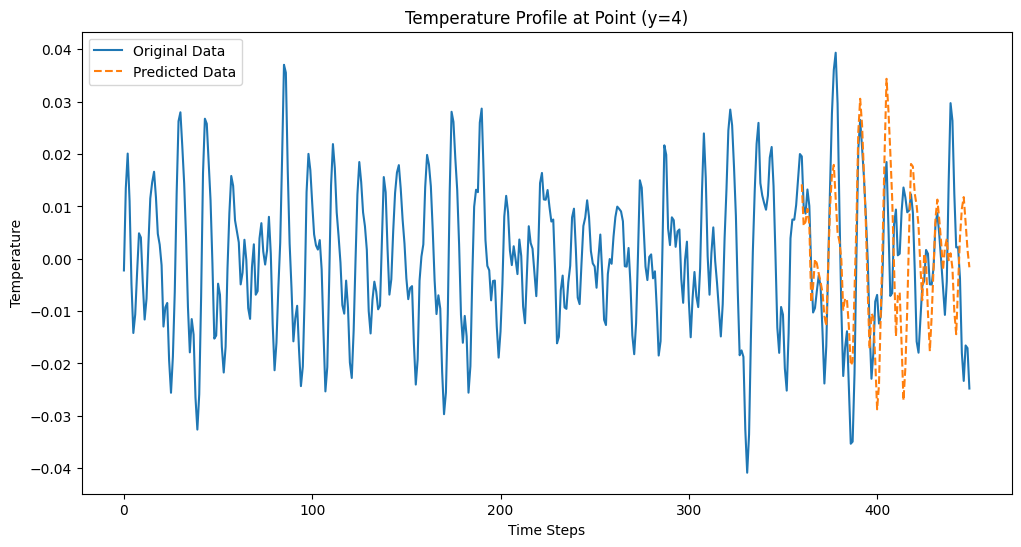

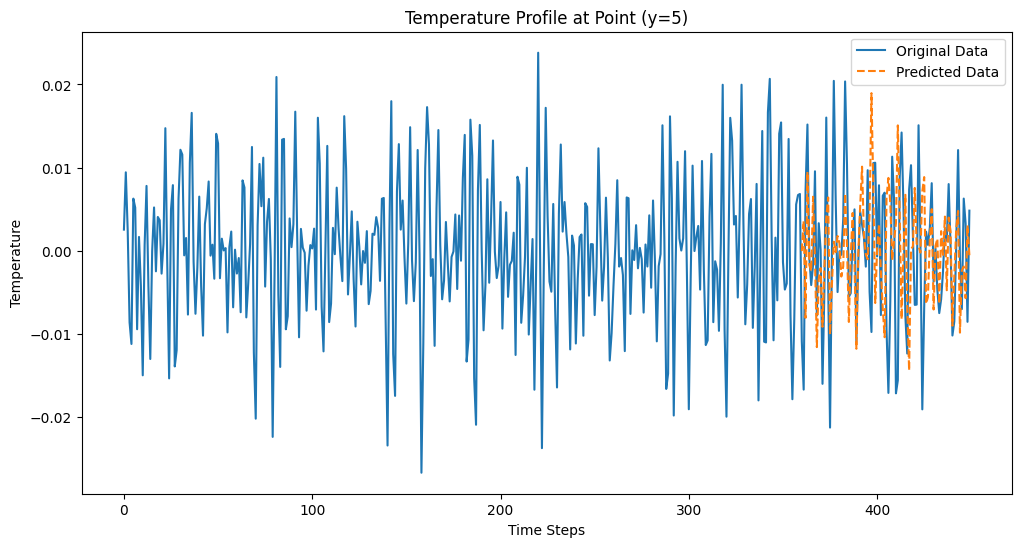

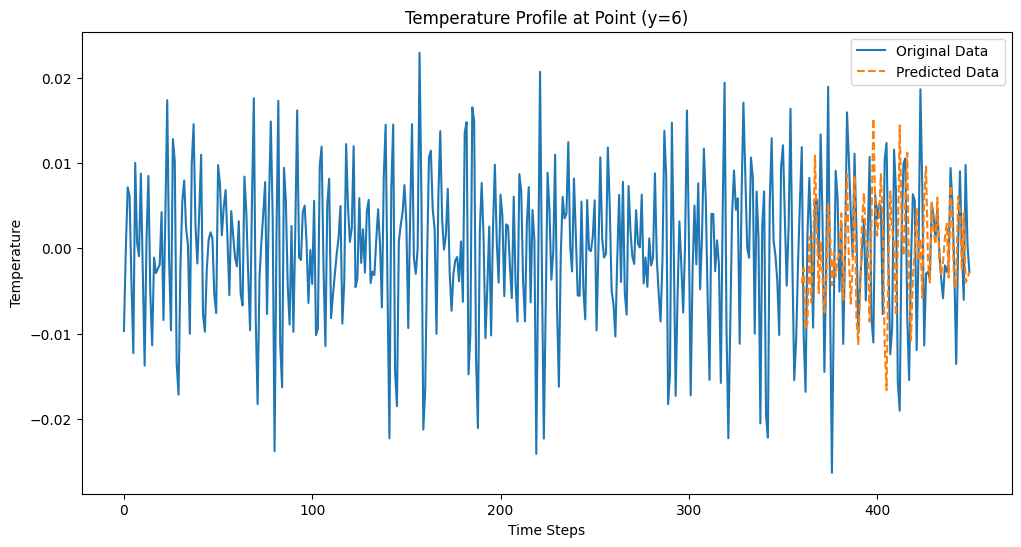

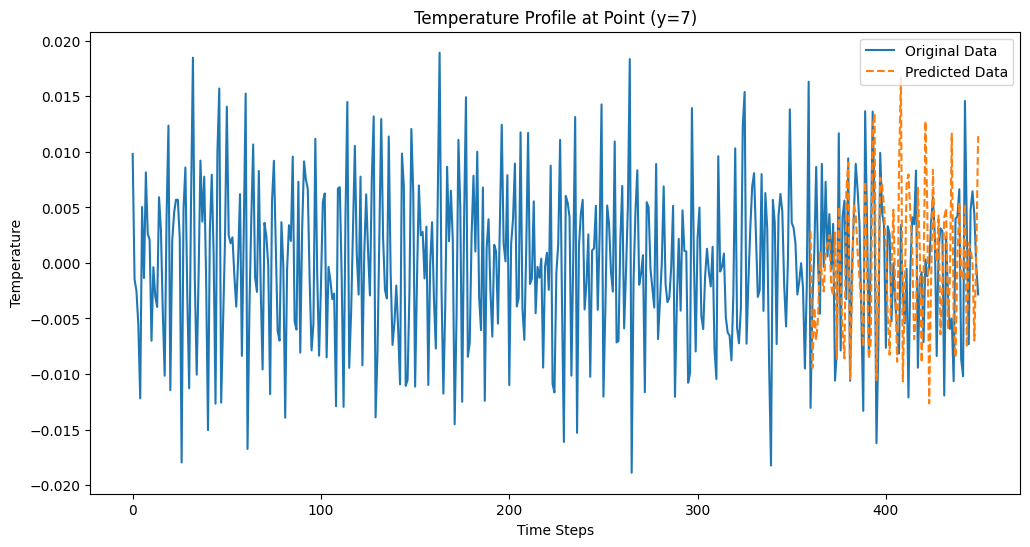

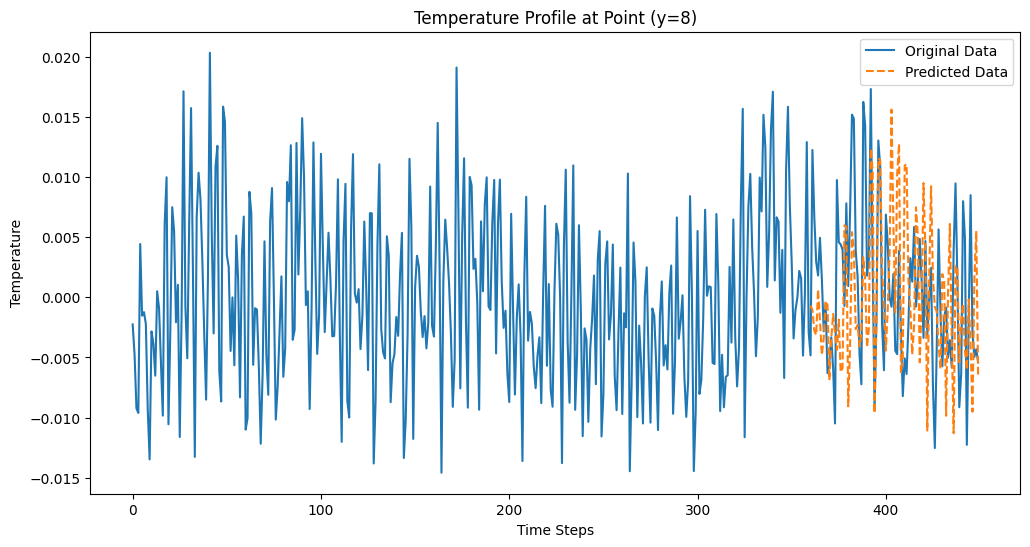

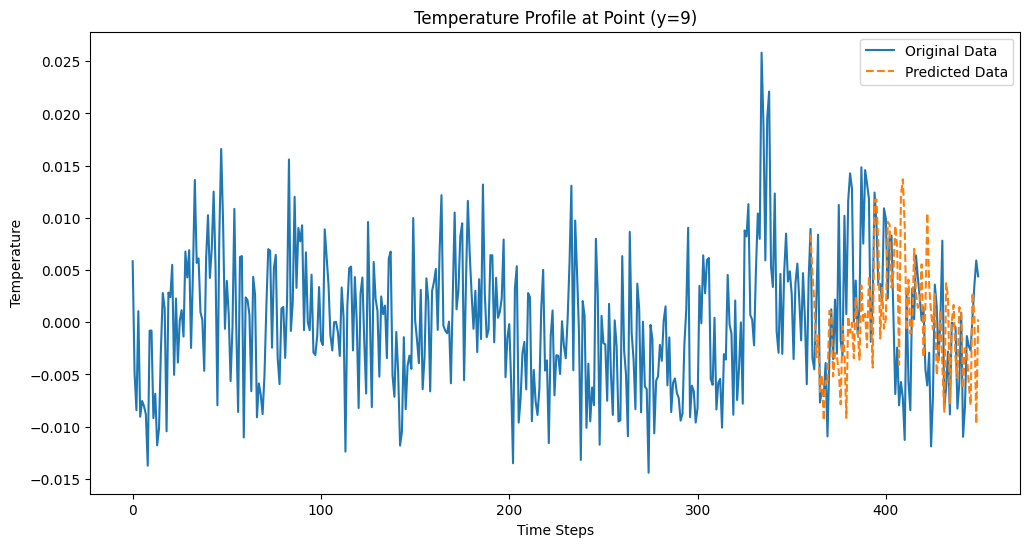

IndexError: index 10 is out of bounds for axis 1 with size 10

<Figure size 1200x600 with 0 Axes>

In [ ]:

closest_index = 4


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()




closest_index = 5


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()


closest_index = 6


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()


closest_index = 7


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()



closest_index = 8


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()



closest_index = 9


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()




closest_index = 10


# Plotting original and predicted values for the specific grid point
plt.figure(figsize=(12, 6))
time_steps = np.arange(len(data))
original_temp_profile = np.vstack((train_data, predict_data))[:, closest_index]
predicted_temp_profile = predicted_data[:, closest_index]
prediction_steps = np.arange(len(data) - predicted_temp_profile.shape[0], len(data))

plt.plot(time_steps, scaler.inverse_transform(data)[:, closest_index], label="Original Data")
plt.plot(prediction_steps, predicted_temp_profile, label="Predicted Data", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title(f"Temperature Profile at Point (y={closest_index})")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


num_levels=120


# Plotting actual temperatures at timestep 500
plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, timestep_500_actual, levels=num_levels, cmap='jet')
plt.colorbar(label="Actual Temperature")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Actual Temperature at Timestep 500")
plt.tight_layout()
plt.show()

# Plotting predicted temperatures at timestep 500
plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, timestep_500_predicted, levels=num_levels, cmap='jet')
plt.colorbar(label="Predicted Temperature")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Predicted Temperature at Timestep 500")
plt.tight_layout()
plt.show()

# Plotting the difference between actual and predicted temperatures
temperature_difference = timestep_500_actual - timestep_500_predicted

plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, temperature_difference, levels=num_levels, cmap='jet')
plt.colorbar(label="Temperature Difference (Actual - Predicted)")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Difference Between Actual and Predicted Temperatures at Timestep 500")
plt.tight_layout()
plt.show()


NameError: name 'x_coords' is not defined

<Figure size 1600x300 with 0 Axes>

In [ ]:
# Extract the 550th timestep for actual and predicted data
timestep_550_actual = UNORMALISED_data[550, :]  # Actual temperature data at timestep 550
timestep_550_predicted = predicted_data[69, :]  # Predicted temperature data at timestep 550

num_levels=120

# Plotting actual temperatures at timestep 550
plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, timestep_550_actual, levels=num_levels, cmap='jet')
plt.colorbar(label="Actual Temperature")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Actual Temperature at Timestep 550")
plt.tight_layout()
plt.show()

# Plotting predicted temperatures at timestep 550
plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, timestep_550_predicted, levels=num_levels, cmap='jet')
plt.colorbar(label="Predicted Temperature")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Predicted Temperature at Timestep 550")
plt.tight_layout()
plt.show()

# Plotting the difference between actual and predicted temperatures
temperature_difference_550 = timestep_550_actual - timestep_550_predicted

plt.figure(figsize=(16, 3))
plt.tricontourf(x_coords, y_coords, temperature_difference_550, levels=num_levels, cmap='jet')
plt.colorbar(label="Temperature Difference (Actual - Predicted)")
plt.xlim([0, 7])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.title("Difference Between Actual and Predicted Temperatures at Timestep 550")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Timestep information
actual_timesteps = [490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]  # Actual timesteps in the dataset
predicted_indices = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109]    # Corresponding indices in the predicted data

# Function to plot data
def plot_temperature_data(x_coords, y_coords, actual_data, predicted_data, timestep, num_levels=120):
    # Plot actual temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, actual_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Actual Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Actual Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot predicted temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, predicted_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Predicted Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Predicted Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot temperature difference
    temperature_difference = actual_data - predicted_data
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, temperature_difference, levels=num_levels, cmap='jet')
    plt.colorbar(label="Temperature Difference (Actual - Predicted)")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Difference Between Actual and Predicted Temperatures at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

# Coordinates of all points from grid data
x_coords = xy[:, 0]  # x-coordinates of all grid points
y_coords = xy[:, 1]  # y-coordinates of all grid points

# Loop over timesteps and plot data
for actual_timestep, predicted_index in zip(actual_timesteps, predicted_indices):
    actual_data = UNORMALISED_data[actual_timestep, :]
    predicted_data_t= predicted_data[predicted_index, :]
    plot_temperature_data(x_coords, y_coords, actual_data, predicted_data_t, actual_timestep)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the 2nd norm (Euclidean norm) of the difference
norm_differences = []

for actual_timestep, predicted_index in zip(actual_timesteps, predicted_indices):
    actual_data = UNORMALISED_data[actual_timestep, :]
    predicted_data_t = predicted_data[predicted_index, :]

    # Compute the L2 norm of the difference
    norm_diff = np.linalg.norm(actual_data - predicted_data_t, ord=2)
    norm_differences.append(norm_diff)

# Plot the norm of the difference over timesteps
plt.figure(figsize=(8, 5))
plt.plot(actual_timesteps, norm_differences, marker='o', linestyle='-', color='b', label="2nd Norm of Difference")
plt.xlabel("Timestep")
plt.ylabel("L2 Norm of Difference")
plt.title("Euclidean Norm of Temperature Differences Over Time")
plt.grid(True)
plt.legend()
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Timestep information
actual_timesteps = [490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]  # Actual timesteps in the dataset
predicted_indices = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109]    # Corresponding indices in the predicted data

# Function to plot data
def plot_temperature_data(x_coords, y_coords, actual_data, predicted_data, timestep, num_levels=80):
    # Plot actual temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, actual_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Actual Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Actual Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot predicted temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, predicted_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Predicted Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Predicted Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot norm of temperature difference
    norm_difference = np.abs(actual_data - predicted_data)  # Absolute difference at each spatial point
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, norm_difference, levels=num_levels, cmap='jet')
    plt.colorbar(label="||Actual - Predicted|| (L2 Norm per Point)")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Norm of Difference Between Actual and Predicted Temperatures at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

# Coordinates of all points from grid data
x_coords = xy[:, 0]  # x-coordinates of all grid points
y_coords = xy[:, 1]  # y-coordinates of all grid points

# Loop over timesteps and plot data
for actual_timestep, predicted_index in zip(actual_timesteps, predicted_indices):
    actual_data = UNORMALISED_data[actual_timestep, :]
    predicted_data_t = predicted_data[predicted_index, :]
    plot_temperature_data(x_coords, y_coords, actual_data, predicted_data_t, actual_timestep)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the 2nd norm (Euclidean norm) of the difference
norm_differences = []

for actual_timestep, predicted_index in zip(actual_timesteps, predicted_indices):
    actual_data = UNORMALISED_data[actual_timestep, :]
    predicted_data_t = predicted_data[predicted_index, :]

    # Compute the L2 norm of the difference
    norm_diff = np.linalg.norm(actual_data - predicted_data_t, ord=2)
    norm_differences.append(norm_diff)

# Plot the norm of the difference over timesteps
plt.figure(figsize=(8, 5))
plt.plot(actual_timesteps, norm_differences, marker='o', linestyle='-', color='b', label="2nd Norm of Difference")
plt.xlabel("Timestep")
plt.ylabel("L2 Norm of Difference")
plt.title("Euclidean Norm of Temperature Differences Over Time")
plt.grid(True)
plt.legend()
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Timestep information
actual_timesteps = [490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]  # Actual timesteps in the dataset
predicted_indices = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109]    # Corresponding indices in the predicted data

# Function to plot data
def plot_temperature_data(x_coords, y_coords, actual_data, predicted_data, timestep, num_levels=98):
    # Plot actual temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, actual_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Actual Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Actual Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot predicted temperatures
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, predicted_data, levels=num_levels, cmap='jet')
    plt.colorbar(label="Predicted Temperature")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Predicted Temperature at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

    # Plot norm of temperature difference
    norm_difference = np.abs(actual_data - predicted_data)  # Absolute difference at each spatial point
    plt.figure(figsize=(16, 3))
    plt.tricontourf(x_coords, y_coords, norm_difference, levels=num_levels, cmap='jet')
    plt.colorbar(label="||Actual - Predicted|| (L2 Norm per Point)")
    plt.xlim([0, 7])
    plt.ylim([-0.5, 0.5])
    plt.gca().set_aspect(1)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title(f"Norm of Difference Between Actual and Predicted Temperatures at Timestep {timestep}")
    plt.tight_layout()
    plt.show()

# Coordinates of all points from grid data
x_coords = xy[:, 0]  # x-coordinates of all grid points
y_coords = xy[:, 1]  # y-coordinates of all grid points

# Loop over timesteps and plot data
for actual_timestep, predicted_index in zip(actual_timesteps, predicted_indices):
    actual_data = UNORMALISED_data[actual_timestep, :]
    predicted_data_t = predicted_data[predicted_index, :]
    plot_temperature_data(x_coords, y_coords, actual_data, predicted_data_t, actual_timestep)

